<a href="https://www.kaggle.com/code/deepaksethi/human-stress-prediction?scriptVersionId=126370512" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/human-stress-prediction/Stress.csv


## Loading libraries

In [2]:
import nltk
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
import string

from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize']=(12,6)
sns.set_theme('notebook')

# Loading a file

In [3]:
human_stress=pd.read_csv('/kaggle/input/human-stress-prediction/Stress.csv')

In [4]:
human_stress.head(10)

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005
5,relationships,7tx7et,"(30, 35)",I think he doesn't want to put in the effort f...,1,1.0,1517274027
6,domesticviolence,7iphly,"[25, 30]",It was a big company so luckily I didn't have ...,0,0.8,1512854409
7,anxiety,5m3k80,"(5, 10)",It cleared up and I was okay but. On Monday ...,1,0.8,1483582174
8,relationships,7nhy1v,"(50, 55)",I actually give an assistant half my emergency...,1,0.6,1514843984
9,assistance,61eiq6,"[15, 20]",I just feel like the street life has fucked my...,1,1.0,1490428087


In [5]:
human_stress.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2838 entries, 0 to 2837
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subreddit         2838 non-null   object 
 1   post_id           2838 non-null   object 
 2   sentence_range    2838 non-null   object 
 3   text              2838 non-null   object 
 4   label             2838 non-null   int64  
 5   confidence        2838 non-null   float64
 6   social_timestamp  2838 non-null   int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 155.3+ KB


In [6]:
human_stress['subreddit'].value_counts()

ptsd                584
relationships       552
anxiety             503
domesticviolence    316
assistance          289
survivorsofabuse    245
homeless            168
almosthomeless       80
stress               64
food_pantry          37
Name: subreddit, dtype: int64

# Feature Engineering

In [7]:
human_stress['len']=[len(text) for text in human_stress['text']]

In [8]:
human_stress['label_in_value']=human_stress['label'].map({0:'No Stress',1:"Stress"})

In [9]:
human_stress['date']=[ datetime.fromtimestamp(value) for value in human_stress['social_timestamp']]

In [10]:
human_stress['day']=[value for value in human_stress['date'].dt.day]

In [11]:
human_stress['month']=[value for value in human_stress['date'].dt.month]

In [12]:
human_stress['year']=[value for value in human_stress['date'].dt.year]

In [13]:
human_stress['hour']=[value for value in human_stress['date'].dt.hour]

In [14]:
human_stress['second']=[value for value in human_stress['date'].dt.second]

In [15]:
human_stress['day_name']=[value for value in human_stress['date'].dt.day_name()]

In [16]:
human_stress['day_of_week']=[value for value in human_stress['date'].dt.day_of_week]

In [17]:
human_stress.head(10)

,subreddit,post_id,sentence_range,text,label,confidence,social_timestamp,len,label_in_value,date,day,month,year,hour,second,day_name,day_of_week
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",1,0.8,1521614353,571,Stress,2018-03-21 06:39:13,21,3,2018,6,13,Wednesday,2
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",0,1.0,1527009817,588,No Stress,2018-05-22 17:23:37,22,5,2018,17,37,Tuesday,1
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,1,0.8,1535935605,847,Stress,2018-09-03 00:46:45,3,9,2018,0,45,Monday,0
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",1,0.6,1516429555,1277,Stress,2018-01-20 06:25:55,20,1,2018,6,55,Saturday,5
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1,0.8,1539809005,533,Stress,2018-10-17 20:43:25,17,10,2018,20,25,Wednesday,2
5,relationships,7tx7et,"(30, 35)",I think he doesn't want to put in the effort f...,1,1.0,1517274027,539,Stress,2018-01-30 01:00:27,30,1,2018,1,27,Tuesday,1
6,domesticviolence,7iphly,"[25, 30]",It was a big company so luckily I didn't have ...,0,0.8,1512854409,588,No Stress,2017-12-09 21:20:09,9,12,2017,21,9,Saturday,5
7,anxiety,5m3k80,"(5, 10)",It cleared up and I was okay but. On Monday ...,1,0.8,1483582174,548,Stress,2017-01-05 02:09:34,5,1,2017,2,34,Thursday,3
8,relationships,7nhy1v,"(50, 55)",I actually give an assistant half my emergency...,1,0.6,1514843984,436,Stress,2018-01-01 21:59:44,1,1,2018,21,44,Monday,0
9,assistance,61eiq6,"[15, 20]",I just feel like the street life has fucked my...,1,1.0,1490428087,375,Stress,2017-03-25 07:48:07,25,3,2017,7,7,Saturday,5


# Removing confidence becuase it is causing target leakage

In [18]:
remove_cols=['post_id','sentence_range','confidence','social_timestamp','date']
human_stress.drop(remove_cols,axis=1,inplace=True)

In [19]:
human_stress.groupby('subreddit')['len'].describe().sort_values('count',ascending=False)

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
ptsd,584.0,435.296233,157.677362,6.0,330.00,417.5,524.25,1271.0
relationships,552.0,463.898551,167.292838,142.0,354.00,428.0,539.00,1277.0
anxiety,503.0,447.763419,168.015419,6.0,338.00,418.0,532.50,1358.0
domesticviolence,316.0,436.512658,165.901395,6.0,335.00,406.5,512.25,1308.0
assistance,289.0,429.705882,143.763236,32.0,339.00,417.0,503.00,915.0
survivorsofabuse,245.0,473.485714,194.551557,88.0,348.00,437.0,559.00,1606.0
homeless,168.0,449.851190,177.114248,155.0,342.75,425.5,525.25,1281.0
almosthomeless,80.0,447.412500,208.517777,116.0,329.50,417.5,519.00,1639.0
stress,64.0,505.593750,203.001816,172.0,361.50,492.5,601.25,1354.0


# Data Visualization

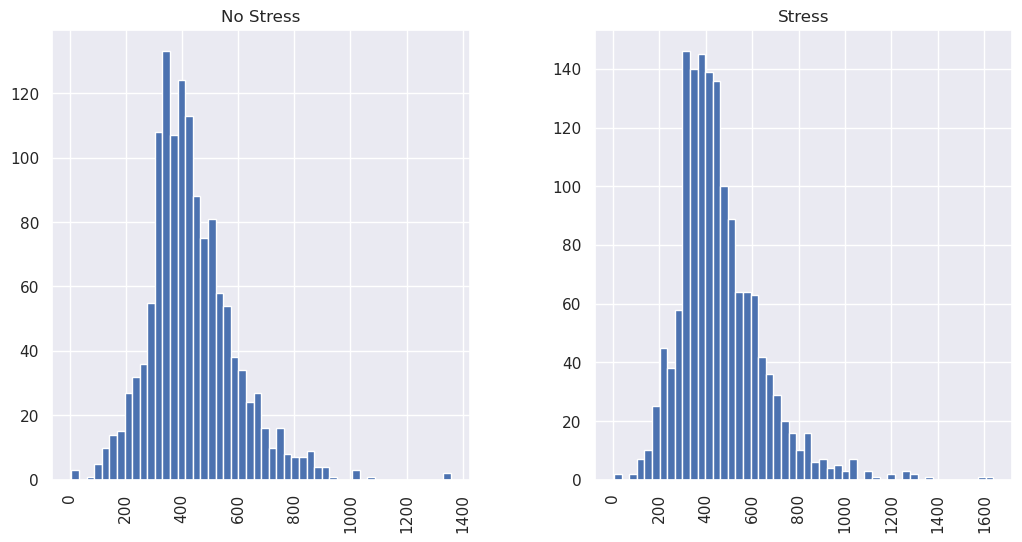

In [20]:
human_stress.hist(column='len',by='label_in_value',bins=50)
plt.show()

# There is hardly any difference between stress and non stress distribution

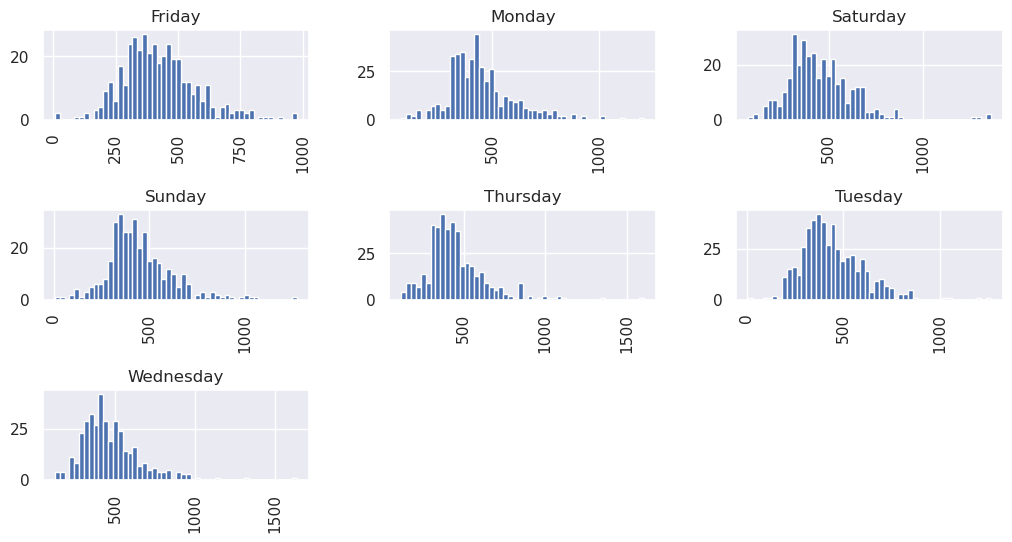

In [21]:
fig, ax = plt.subplots()
human_stress.hist(column='len',by='day_name',bins=50,ax=ax)
plt.subplots_adjust(hspace=1)
plt.show()

# Friday and Tuesday for length of the text are high 

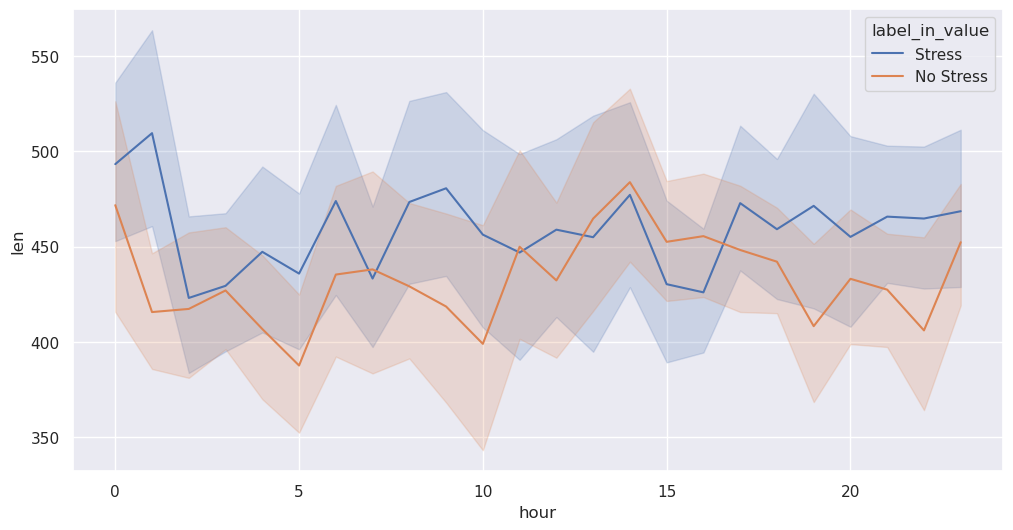

In [22]:
sns.lineplot(data=human_stress,x='hour',y='len',hue='label_in_value')
plt.show()

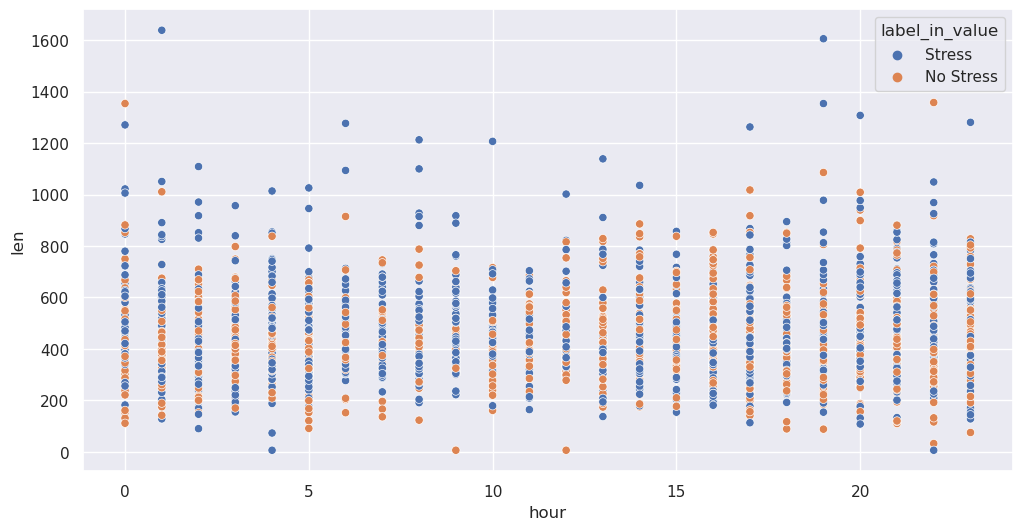

In [23]:
sns.scatterplot(data=human_stress,x='hour',y='len',hue='label_in_value')
plt.show()

# Long texts are a symptom of stress.

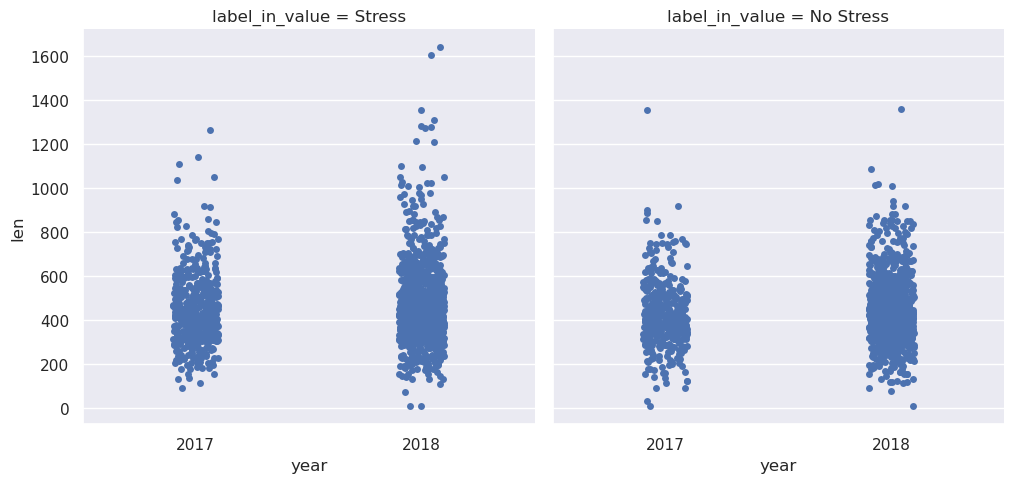

In [24]:
sns.catplot(data=human_stress,x='year',y='len',col='label_in_value',sharex=False,col_wrap=3)
plt.show()

# More length of 1000 text is represent stress and cases has been increased in from 2017 to 2018 

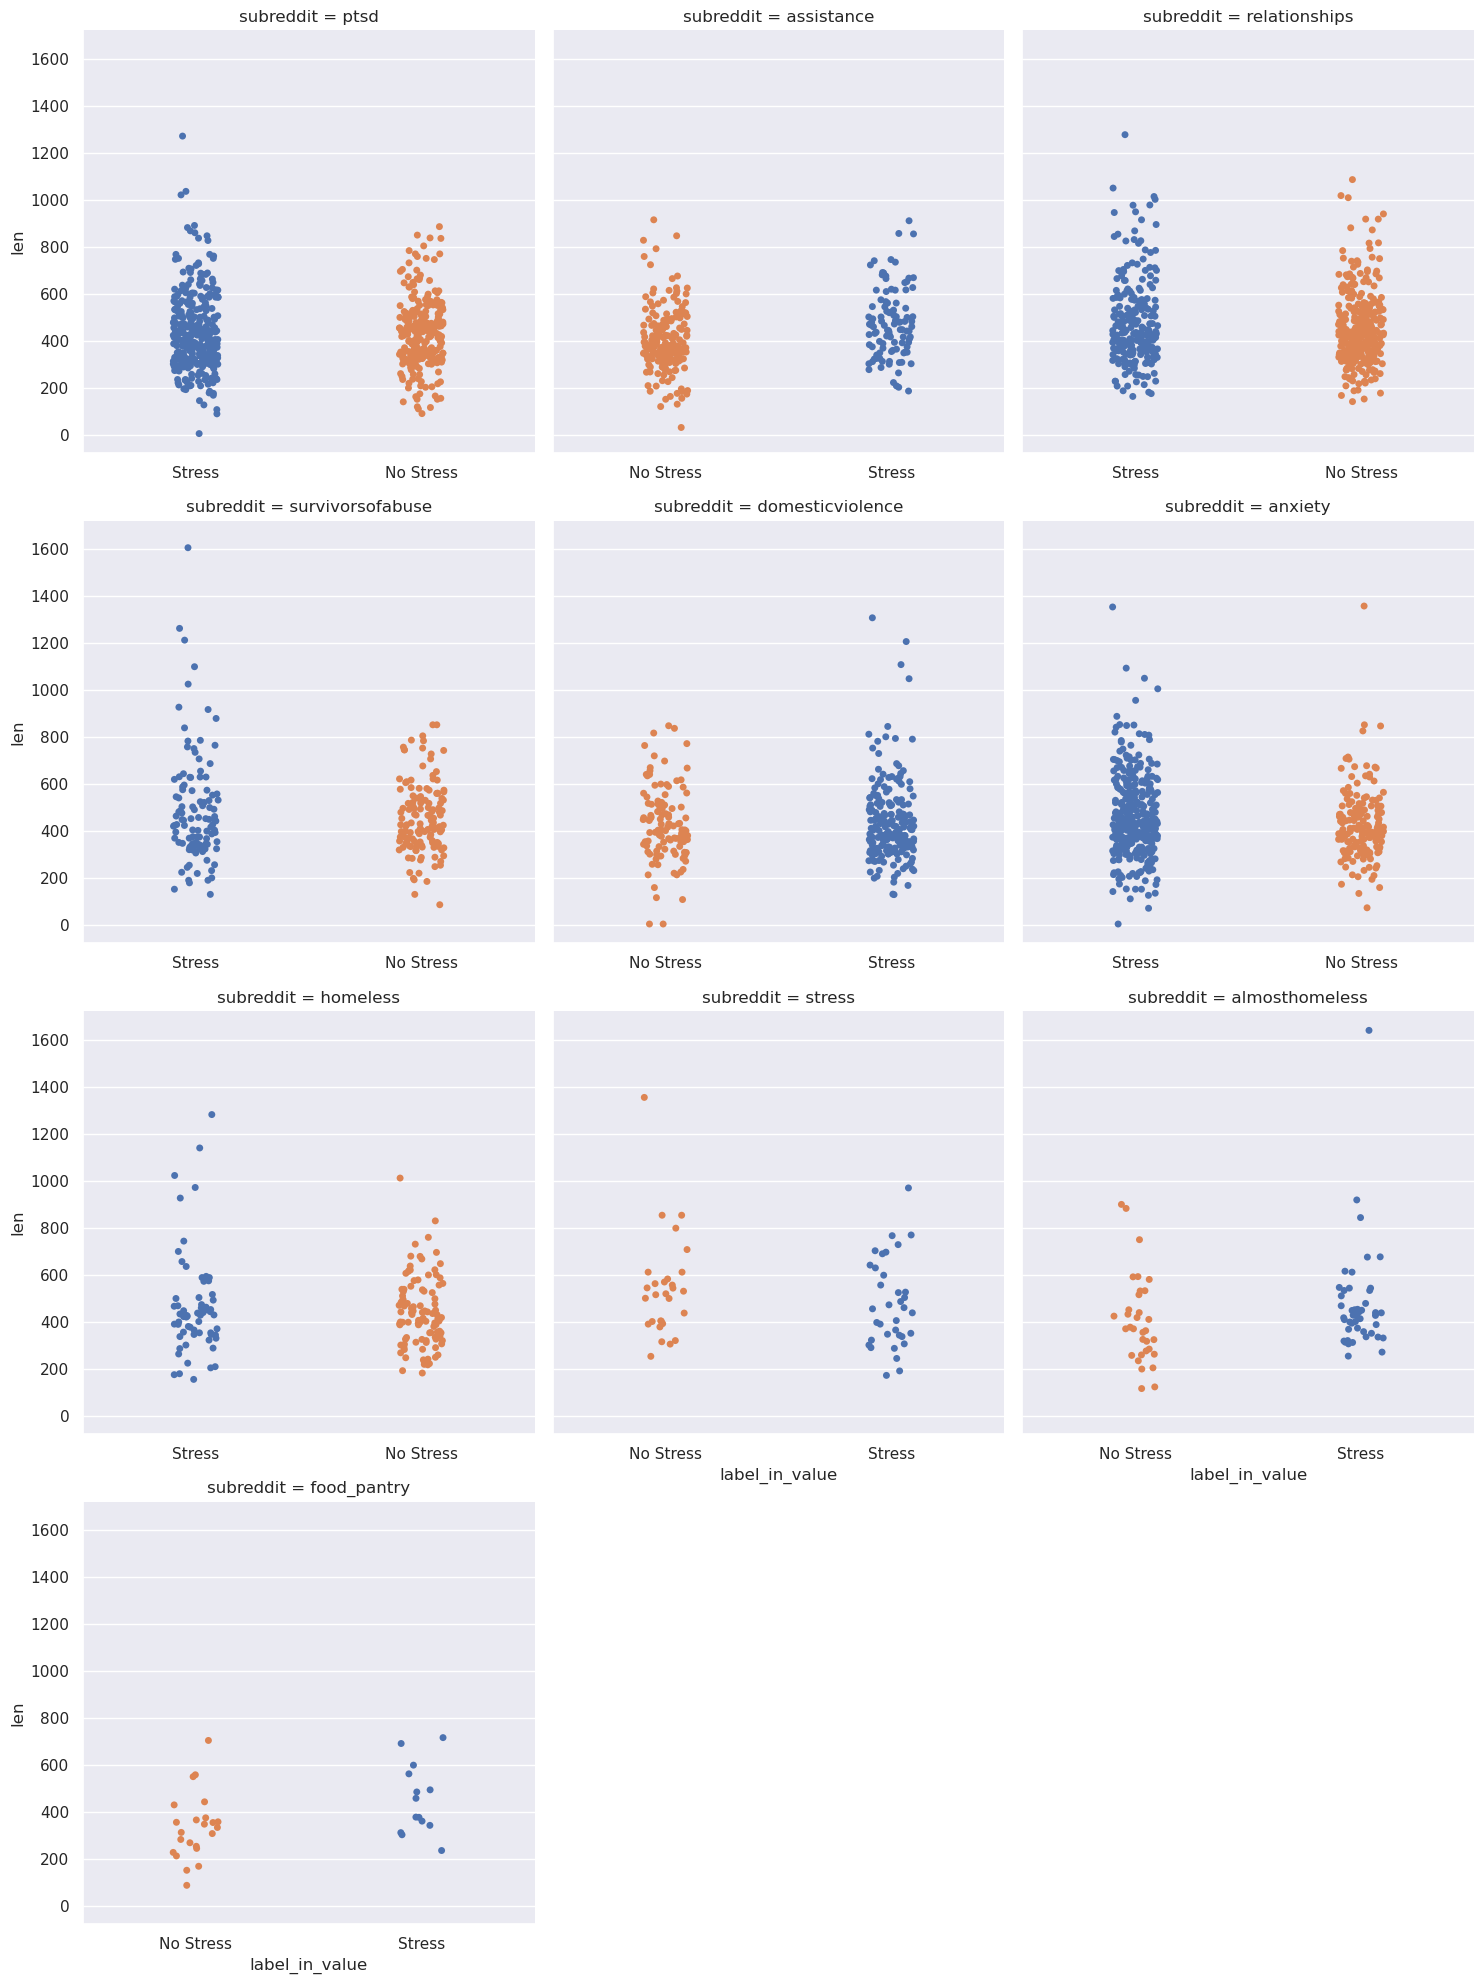

In [25]:
sns.catplot(data=human_stress,x='label_in_value',y='len',col='subreddit',col_wrap=3,hue='label_in_value',sharex=False)
plt.show()

#  Major cases are in 
# 1. ptsd
# 2. survivor of abuse
# 3. Domestic violence
# 4. Anxiety
# 5. Homeless

# Spliting data

In [26]:
X=human_stress['text'].values
y=human_stress['label_in_value'].values

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Function for cleaning the text 

In [28]:
def text_clean(text_message):
    
    remove_punc=[ text for text in text_message if text not in string.punctuation]
    
    remove_punc= ''.join(remove_punc)
    
    return [word for word in remove_punc.split() if word.lower() not in stopwords.words('english')]

# Testing of function

In [29]:
human_stress['text'].head(5)

0    He said he had not felt that way before, sugge...
1    Hey there r/assistance, Not sure if this is th...
2    My mom then hit me with the newspaper and it s...
3    until i met my new boyfriend, he is amazing, h...
4    October is Domestic Violence Awareness Month a...
Name: text, dtype: object

In [30]:
human_stress['text'].head(5).apply(text_clean)

0    [said, felt, way, suggeted, go, rest, TRIGGER,...
1    [Hey, rassistance, sure, right, place, post, g...
2    [mom, hit, newspaper, shocked, would, knows, d...
3    [met, new, boyfriend, amazing, kind, sweet, go...
4    [October, Domestic, Violence, Awareness, Month...
Name: text, dtype: object

# Approach 1

# Multinomial naive Byes algorithm and Grid search 

In [31]:
parameters = {
    'bow__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'classifier__alpha': (1e-2, 1e-3),
}


# Pipeline

In [32]:
pipeline_clf=Pipeline([('bow',CountVectorizer(analyzer=text_clean)),
                   ('tfidf',TfidfTransformer()),
                   ('classifier',MultinomialNB())
                  ])

In [33]:
gs_clf = GridSearchCV(pipeline_clf, parameters, cv=7)
gs_clf.fit(X_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('bow',
                                        CountVectorizer(analyzer=<function text_clean at 0x77120b3c1680>)),
                                       ('tfidf', TfidfTransformer()),
                                       ('classifier', MultinomialNB())]),
             param_grid={'bow__ngram_range': [(1, 1), (1, 2)],
                         'classifier__alpha': (0.01, 0.001),
                         'tfidf__use_idf': (True, False)})

In [34]:
predictions=gs_clf.predict(X_test)

In [35]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

   No Stress       0.76      0.57      0.65       335
      Stress       0.69      0.84      0.76       375

    accuracy                           0.71       710
   macro avg       0.72      0.70      0.70       710
weighted avg       0.72      0.71      0.71       710



# Approach 2

# Deep Learning - Natural Language Processing

In [36]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

print(tf.__version__)

2.11.0


# Copying the data in new variable

In [37]:
human_stree_nlp=human_stress.copy()

# Spliting data again

In [38]:
X_train_nlp, X_test_nlp, y_train_nlp, y_test_nlp = train_test_split(human_stree_nlp['text'], human_stree_nlp['label'], test_size=0.20, random_state=42)

# Cleaning the text column of train data and test data

In [39]:
X_train_nlp=X_train_nlp.apply(text_clean)

In [40]:
X_test_nlp= X_test_nlp.apply(text_clean)

# Defining the parameters for tokenizing and padding

In [41]:
vocab_size=50000
embedding_dim=96
max_length=2000
trunc_type='post'
oov_tok="<oov>"


In [42]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train_nlp)
word_index = tokenizer.word_index

##training sequences and labels
train_seqs = tokenizer.texts_to_sequences(X_train_nlp)
train_padded = pad_sequences(train_seqs, maxlen=max_length, truncating=trunc_type)

##testing sequences and labels
test_seqs = tokenizer.texts_to_sequences(X_test_nlp)
test_padded = pad_sequences(test_seqs,maxlen=max_length)

# Define a model of NLP

In [43]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(72, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

##compile the model with loss function, optimizer and metrics
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 96)          4800000   
                                                                 
 global_average_pooling1d (G  (None, 96)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 72)                6984      
                                                                 
 dense_1 (Dense)             (None, 1)                 73        
                                                                 
Total params: 4,807,057
Trainable params: 4,807,057
Non-trainable params: 0
_________________________________________________________________


# Training a model

In [44]:
num_epochs = 50

##train the model with training and validation set
history = model.fit(
    train_padded,   #training sequence
    y_train_nlp, # training labels
    epochs=num_epochs, 
    validation_data=(test_padded, y_test_nlp) # test data
    )

Epoch 1/50
71/71 [==============================] - 5s 61ms/step - loss: 0.6926 - accuracy: 0.5211 - val_loss: 0.6917 - val_accuracy: 0.5370
Epoch 2/50
71/71 [==============================] - 4s 50ms/step - loss: 0.6929 - accuracy: 0.5211 - val_loss: 0.6910 - val_accuracy: 0.5370
Epoch 3/50
71/71 [==============================] - 4s 51ms/step - loss: 0.6921 - accuracy: 0.5211 - val_loss: 0.6901 - val_accuracy: 0.5370
Epoch 4/50
71/71 [==============================] - 4s 52ms/step - loss: 0.6922 - accuracy: 0.5211 - val_loss: 0.6915 - val_accuracy: 0.5370
Epoch 5/50
71/71 [==============================] - 4s 52ms/step - loss: 0.6919 - accuracy: 0.5211 - val_loss: 0.6898 - val_accuracy: 0.5370
Epoch 6/50
71/71 [==============================] - 4s 52ms/step - loss: 0.6913 - accuracy: 0.5211 - val_loss: 0.6896 - val_accuracy: 0.5370
Epoch 7/50
71/71 [==============================] - 4s 54ms/step - loss: 0.6905 - accuracy: 0.5211 - val_loss: 0.6904 - val_accuracy: 0.5423
Epoch 8/50
71

# Visualizating the loss and accuracy of train data and test data

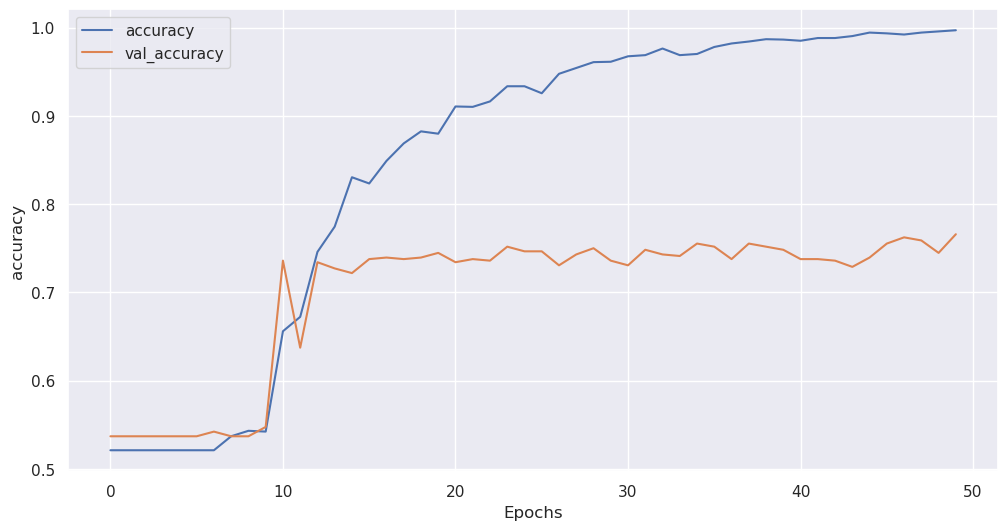

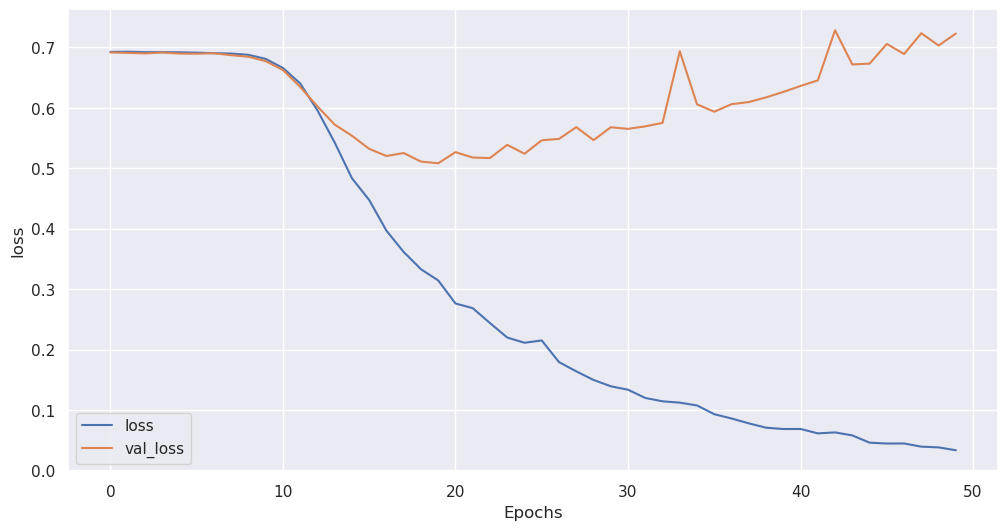

In [45]:
##plot the scores from history
def plot_metrics(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+ metric])
  plt.legend([metric, 'val_'+ metric])
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.show()
  
##plot accuracy
plot_metrics(history, "accuracy")

##plot loss
plot_metrics(history, "loss")

# checking the model with unseen random inputs

In [46]:
sentence = ["I am not feeling happy", 
            "these days i have been working on crucial projects and i have to focus on time delivery",
            "i am on holidays",
            'I bet all my money yesterday and lost it all ',
            "My girlfriend is in the hospital",
           "I lost my job",
            "This year i am not going to this my current year goal and i do not know how i am going to deal with this",
           "The stress is affecting every aspect of my life. I'm not enjoying things I used to, and I'm struggling to find joy in anything",
           "I'm constantly second-guessing myself and worrying about making mistakes. The stress is making it hard to make even simple decisions",
           "I'm struggling to find the motivation to do anything. The stress has drained my energy and left me feeling hopeless",
           "I feel like I'm in a constant state of crisis"]

##prepare the sequences of the sentences in question
sequences = tokenizer.texts_to_sequences(sentence)
padded_seqs = pad_sequences(sequences, maxlen=max_length, truncating=trunc_type)

##print the classification score
# print(model.predict(padded_seqs))
output={}
for i,seq in enumerate(padded_seqs):
    output[sentence[i]]=model.predict(np.array([seq]))[0]
output = pd.DataFrame.from_dict(output, orient='index', columns=['prediction'])
output.index.name = 'sentence'
output=output.reset_index()
print(output)

1/1 [==============================] - 0s 25ms/step
                                             sentence  prediction
0                              I am not feeling happy    0.222474
1   these days i have been working on crucial proj...    0.204234
2                                    i am on holidays    0.124156
3       I bet all my money yesterday and lost it all     0.424836
4                    My girlfriend is in the hospital    0.198322
5                                       I lost my job    0.389132
6   This year i am not going to this my current ye...    0.401108
7   The stress is affecting every aspect of my lif...    0.404534
8   I'm constantly second-guessing myself and worr...    0.792017
9   I'm struggling to find the motivation to do an...    0.651524
10      I feel like I'm in a constant state of crisis    0.793261


# The value ranges from 0 to 0.5 indicate no stress, and as the values climb from 0.5 to 1, the degree of stress is likewise increased. This shows how effectively the model has done. 

# Please upvote and leave a comment if you enjoy my work. All recommendations are welcome. 